# Location Analysis

* Module Name: location.ipynb
* Description: perform nalysis on location data we capture from the pipeline

Copyright (C) 2025 J.Cincotta

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program. If not, see <https://www.gnu.org/licenses/>.


In [1]:
from torch.nn.functional import threshold

"""
Configuration for this notebook:
"""

filename: str = "final-output.csv"
historic_sample_window_size: int = 10
dwell_distance_threshold: float = 5.0
# this reflects the values in the COCOs training data
names = ["Zarafa", "Ebo", "Jimiyu", "Kito"]

## Import data 

Super quick and dirty CSV loader that parses the `( xx | zz )` coordinate strings back into a list of tuples.

The resulting data structure is:

* Sample dict with the keys representing samples.
* Every sample contains a dict with key representing individuals identifier.
* The content of the individual dict are two keys: "intersect" and "timestamp"
* "intersect" contains an array of x,z coordinates as tuples.

In [2]:
import csv
from datetime import datetime


def parse(src: str) -> list:
    return [(int(o.partition("|")[0].strip()), int(o.partition("|")[2].strip())) for o in src.replace(")","").split("(") if o]


samples: dict = {}
row_count = 0
sample_count = 0
with open(filename, "r") as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        if int(row["sample"].strip()) > sample_count:
            sample_count = int(row["sample"].strip())
        sample = samples.get(row["sample"], {})
        identity = sample.get(row["identity"], {})
        identity["intersect"] = parse(row["intersect"])
        identity["timestamp"] = datetime.strptime(row["timestamp"], '%Y-%m-%d %H:%M:%S')
        sample[row["identity"]] = identity
        samples[row["sample"]] = sample
        row_count += 1

print(f"Imported {filename} with {row_count} rows containing {sample_count} samples.")


Imported final-output.csv with 16 rows containing 5 samples.


## Identify individuals

In [3]:
identities: list = []
for sample in samples.keys():
    for individual in samples[sample].keys():
        if individual not in identities:
            identities.append(individual)

print(f"Found the following individuals: {[names[int(o) - 1] for o in identities]}")


Found the following individuals: ['Jimiyu', 'Zarafa', 'Ebo', 'Kito']


## Identify the start and end time of the sampling period

In [4]:
from datetime import datetime


times: list = []
for sample in samples.keys():
    for individual in samples[sample].keys():
        times.append(samples[sample][individual]["timestamp"])
        # print(samples[sample][individual]["timestamp"].strftime('%Y-%m-%d %H:%M:%S'))

start_time = min(times)
end_time = max(times)
sampling_time_span = end_time - start_time

print(f"Sample range: {start_time.strftime('%Y-%m-%d %H:%M:%S')} to {end_time.strftime('%Y-%m-%d %H:%M:%S')} ({sampling_time_span})")



Sample range: 2025-03-10 10:28:07 to 2025-03-10 10:28:27 (0:00:20)


## Identify the delta of the individual from the previous sample. 

This is achieved by using centroid distance between the clusters representing the location at two samples (times).

Note that we can effectively use centroid distance and nothing more complex here since these points have been pre-processed with DBScan and outliers have been removed already.

In [5]:
import numpy as np


def centroid_distance(cluster1, cluster2):
    centroid1 = np.mean(cluster1, axis=0)
    centroid2 = np.mean(cluster2, axis=0)
    return np.linalg.norm(centroid1 - centroid2)


previous_sample_key = None
for sample_key in samples.keys():
    for identity_key in identities:
        if identity_key in samples[sample_key].keys():
            samples[sample_key][identity_key]["centroid-distance"] = 0
            if previous_sample_key in samples.keys():
                if identity_key in samples[sample_key].keys() and identity_key in samples[previous_sample_key].keys():
                    samples[sample_key][identity_key]["centroid-distance"] = float(centroid_distance(
                        np.array(samples[sample_key][identity_key]["intersect"]),
                        np.array(samples[previous_sample_key][identity_key]["intersect"])
                    ))

    previous_sample_key = sample_key

print(f"Calculated centroids for {len(samples)} samples.")


Calculated centroids for 5 samples.


## Use thresholding to deterime the difference between dwell and locomotion

In [6]:
import numpy as np


def centroid_distance(cluster1, cluster2):
    centroid1 = np.mean(cluster1, axis=0)
    centroid2 = np.mean(cluster2, axis=0)
    return np.linalg.norm(centroid1 - centroid2)


identity_history: dict = {}
tmp_ss = historic_sample_window_size * -1

for identity_key in identities:
    identity_history[identity_key] = []

for sample_key in samples.keys():
    for identity_key in identities:
        if identity_key in samples[sample_key].keys():
            identity_history[identity_key].append(samples[sample_key][identity_key]["centroid-distance"])
            threshold_value = sum(identity_history[identity_key][tmp_ss:])
            samples[sample_key][identity_key]["action-threshold"] = threshold_value
            if threshold_value < dwell_distance_threshold:
                samples[sample_key][identity_key]["action-label"] = "dwell"
            else:
                samples[sample_key][identity_key]["action-label"] = "move"
        else:
            samples[sample_key][identity_key] = {}
            samples[sample_key][identity_key]["action-label"] = "not-detected"
            samples[sample_key][identity_key]["action-threshold"] = 0
            samples[sample_key][identity_key]["centroid-distance"] = 0
            samples[sample_key][identity_key]["intersect"] = None

print(f"Calculated threshold and actions for {len(samples)} samples.")


Calculated threshold and actions for 5 samples.


## Summarise usage

In [ ]:
for identity_key in identities:
    points = None
    for sample_key in samples.keys():
        

## Use convex hull to identify habitat usage (area covered by samples over mapped habitat area)

In [7]:
from scipy.spatial import ConvexHull


for identity_key in identities:
    points = None
    for sample_key in samples.keys():
        if samples[sample_key][identity_key]["intersect"] is not None:
            if points is None:
                points = np.array(samples[sample_key][identity_key]["intersect"])
            else:
                points = np.concatenate((points, np.array(samples[sample_key][identity_key]["intersect"])), axis=0)
    hull = ConvexHull(points + 128)
    area = hull.area
    print(f"Over the period {sampling_time_span} =>  {names[int(identity_key) - 1]} area usage {(area/(255*255)*100)}% of total measured area.")


Over the period 0:00:20 =>  Jimiyu area usage 1.070887979490646% of total measured area.
Over the period 0:00:20 =>  Zarafa area usage 0.9983632459724945% of total measured area.
Over the period 0:00:20 =>  Ebo area usage 0.8064418816873283% of total measured area.
Over the period 0:00:20 =>  Kito area usage 1.0420026048361533% of total measured area.


Use clustering to identify towering

## Heatmap

Found the following individuals: ['Jimiyu', 'Zarafa', 'Ebo', 'Kito']


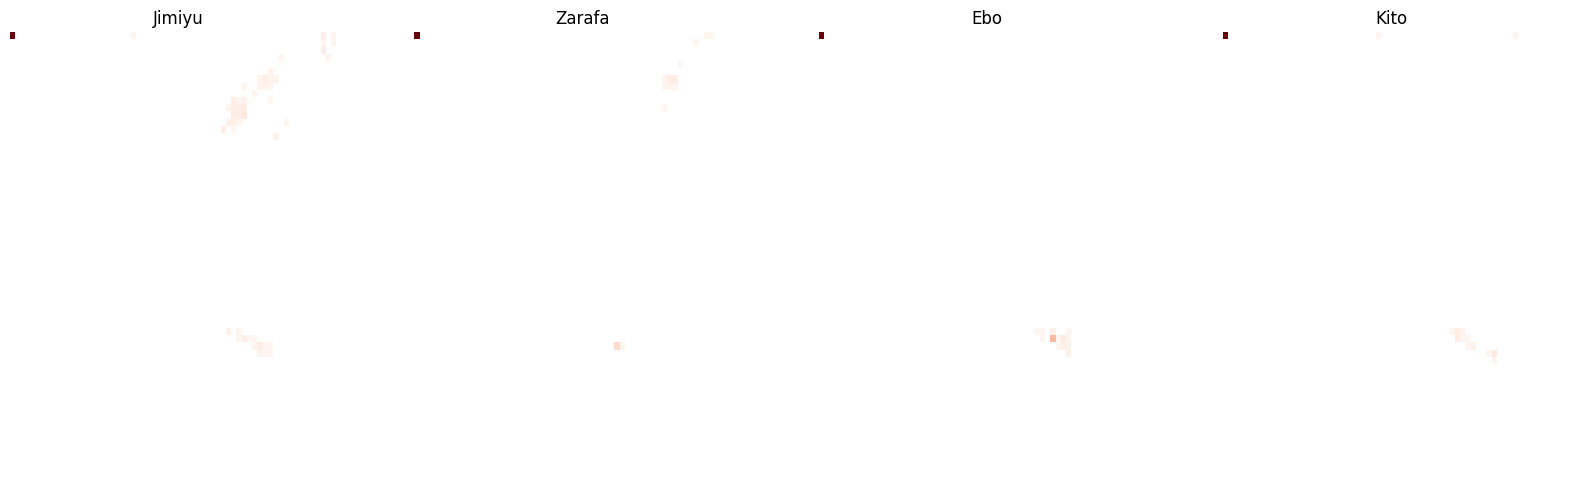

In [11]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Parameters for the random walk
grid_size = 32   # Size of the 2D grid
map_size = 256
reduction = map_size / grid_size
identity_grids = {}

for identity_key in identities:
    identity_grids[identity_key] = np.zeros((grid_size, grid_size))
    points = None
    for sample_key in samples.keys():
        if samples[sample_key][identity_key]["intersect"] is not None:
            if points is None:
                points = np.array(samples[sample_key][identity_key]["intersect"])
            else:
                points = np.concatenate((points, np.array(samples[sample_key][identity_key]["intersect"])), axis=0)
    points += 128
    for x, y in points:
        identity_grids[identity_key][int(x/reduction), int(y/reduction)] += 1

fig, axes = plt.subplots(1, len(identity_grids.keys()), figsize=(20, 6))

for ax, grid in zip(axes, identity_grids.values()):
    sns.heatmap(
        grid, 
        cmap="Reds", 
        alpha=1.0, 
        cbar=False, 
        mask=np.where(grid > 0.25, 0, 1), 
        ax=ax,
        xticklabels=False,
        yticklabels=False        
    )

print(f"Found the following individuals: {[names[int(o) - 1] for o in identities]}")

for index, i in enumerate(identities):
    axes[index].set_title(names[int(i) - 1])
plt.show()